### Part 1 - data visualization

#### Preliminaries

First we import the libraries we will need, and the data.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
import seaborn as sns
import math, dcor

%matplotlib inline

#### Data loading and inspection

The data (public) is from the paper [Many correlation coefficients, null hypoteses, and high value (Hunt, 2013)](https://csegrecorder.com/columns/view/value-of-integrated-geophysics-201312); I used it previously in  my [Geoscience ML notebook 2](https://github.com/mycarta/predict/blob/master/Geoscience_ML_notebook_2.ipynb)
The dependent variable to be predicted, Y, is oil production (measured in tens of barrels of oil per day) from a marine barrier sand.
Independent variables are:

- Gross pay in meters

- Phi-h, with a 3% porosity cut-off

- Position in the reservoir. This is a ranked variable where a value close to 1 means the upper reservoir facies, a value close to 2 means the middle reservoir facies, and a value close to 3 means the lower reservoir facies.

- Pressure drawdown in MPa.

- 2 random variables

- 1 variable added by me (see my [Geoscience ML support notebook](https://github.com/mycarta/predict/blob/master/Geoscience_ML_support_for_notebook_2.ipynb)) as a log transform of Gross pay to simulate extremely highly correlated independent variables. 

In [2]:
data = pd.read_csv('Table2_Hunt_2013_edit.csv')

In [3]:
data

,Gross pay,Phi-h,Position,Pressure,Random 1,Random 2,Gross pay transform,Production
0,0.1,0.5,2.1,19,5,379,3.54,15.10
1,1.0,4.0,1.1,16,13,269,5.79,21.30
2,1.9,19.0,1.0,14,12,245,8.51,22.75
3,3.1,21.7,2.1,17,6,273,11.52,15.72
4,4.1,24.6,2.9,11,10,237,10.16,7.71
5,4.9,39.2,1.1,12,7,278,11.14,22.67
6,5.9,23.6,2.1,13,13,241,15.04,18.11
7,7.0,63.0,2.0,13,20,269,15.10,24.30
8,8.1,72.9,2.9,14,1,248,14.49,24.04
9,8.9,35.6,2.8,16,1,210,16.90,25.11


We can print a list of the variables.

In [4]:
print (list(data))

['Gross pay', 'Phi-h', 'Position', 'Pressure', 'Random 1', 'Random 2', 'Gross pay transform', 'Production']


We can rearrange variable columns, then print a summary of the data and compare the row count to show there are no missing data points.

In [5]:
data = data.loc[:, ['Position', 'Gross pay', 'Phi-h', 'Pressure', 'Random 1', 'Random 2', 'Gross pay transform', 'Production']]
data.describe()

,Position,Gross pay,Phi-h,Pressure,Random 1,Random 2,Gross pay transform,Production
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,1.885714,9.823810,68.880952,15.285714,10.190476,292.714286,16.579524,33.428571
std,0.708721,5.948521,45.167894,2.759400,6.439092,59.429069,6.543793,15.141909
min,1.000000,0.100000,0.500000,10.000000,1.000000,210.000000,3.540000,7.710000
25%,1.100000,4.900000,24.600000,14.000000,6.000000,245.000000,11.520000,22.670000
50%,2.000000,10.000000,72.900000,16.000000,10.000000,273.000000,16.900000,36.420000
75%,2.200000,15.100000,100.000000,17.000000,13.000000,340.000000,21.970000,44.200000
max,2.900000,19.100000,160.000000,20.000000,21.000000,395.000000,29.250000,59.200000


We can also explicitly test to ensure data does not have no missing measurements.

In [6]:
data.isnull().values.any()

False

#### Visualization with a custom correlation matrix

It includes bivariate scatter-plots in the upper triangle, contours in the lower triangle, shape of the bivariate distributions on the diagonal.

To ignore future warning for a [known issue](https://github.com/h5py/h5py/issues/974):

In [7]:
import warnings
warnings.filterwarnings("ignore")

Adding a utility function to annotate individual scatterplots with rank correlation coefficient. Adapted from [this Stack Overflow answer](https://stackoverflow.com/a/30942817).

In [8]:
def corrfunc(x, y, **kws):
    r, _ = sp.stats.spearmanr(x, y)
    ax = plt.gca()
    ax.annotate("CC = {:.2f}".format(r), xy=(.1, .97), xycoords=ax.transAxes, color = 'g', fontsize = 15)


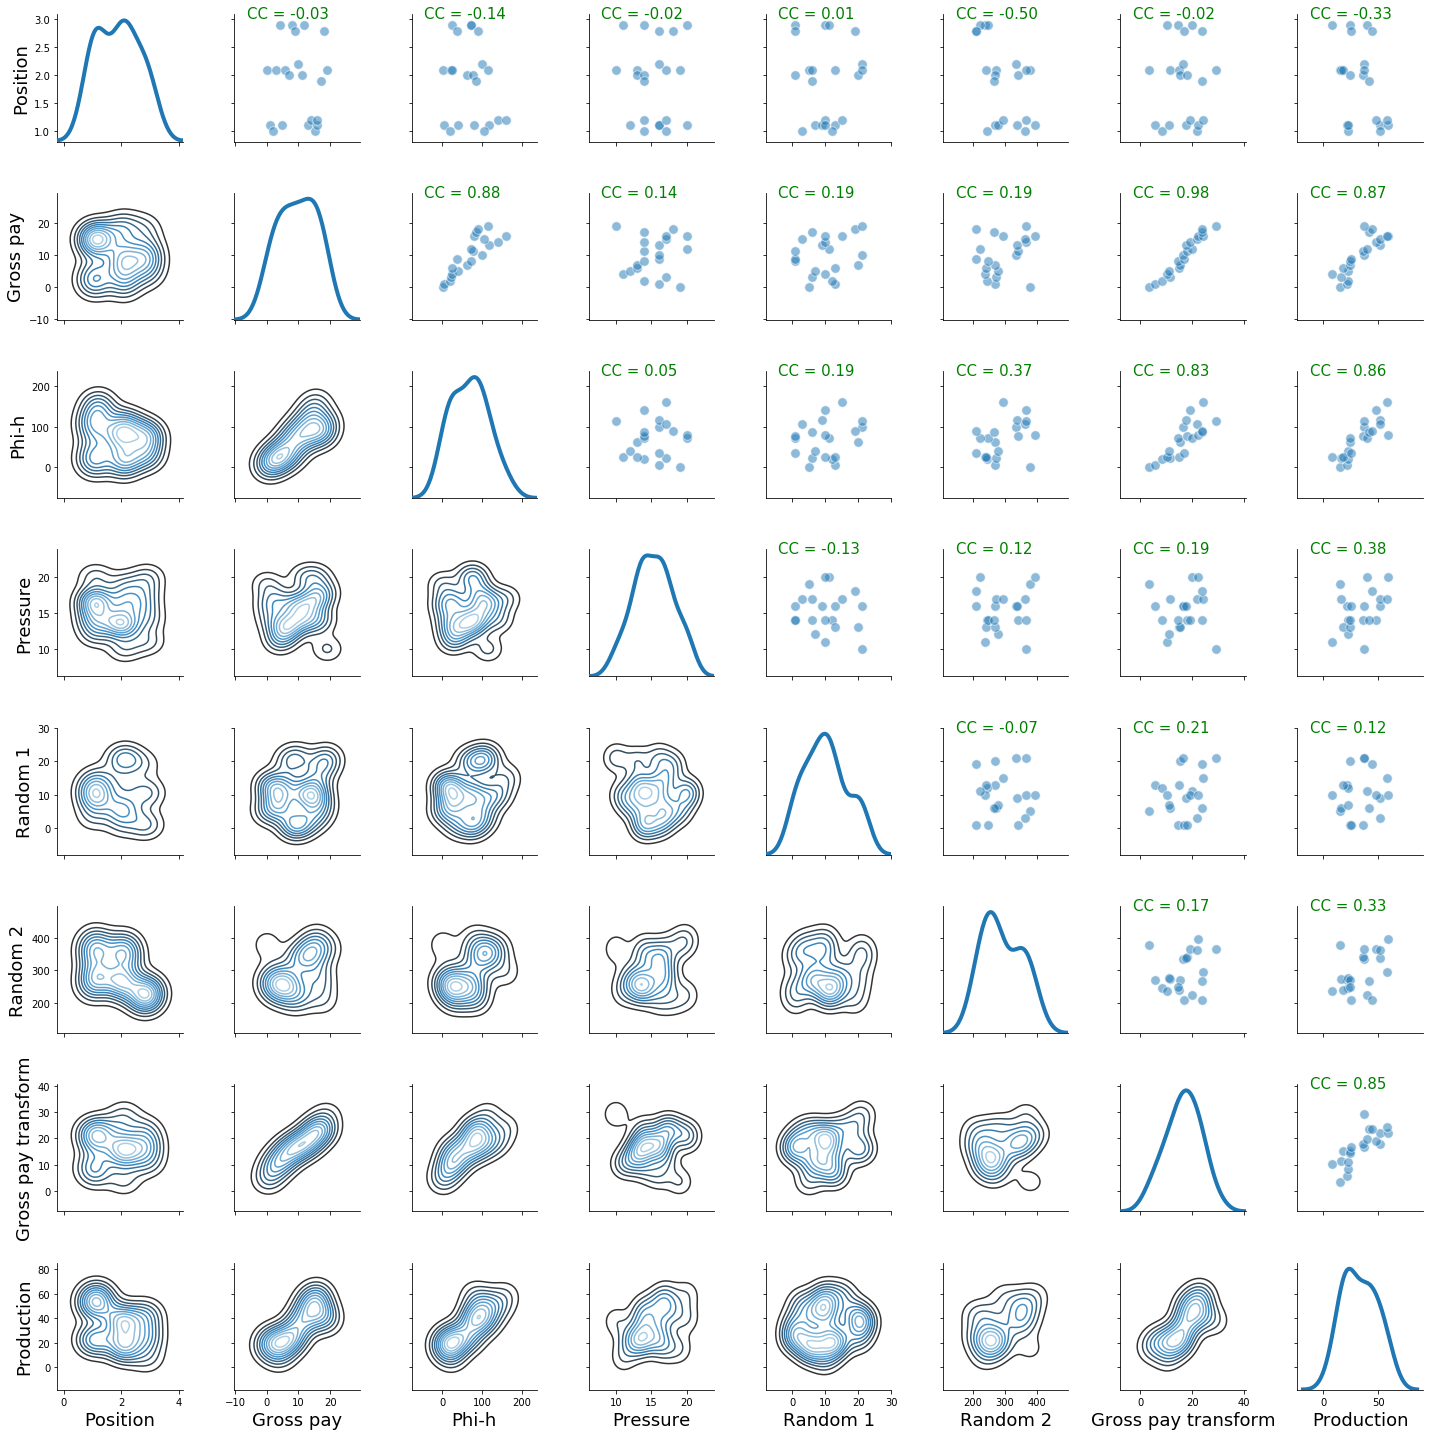

In [9]:
plt.rcParams["axes.labelsize"] = 18
g = sns.PairGrid(data, diag_sharey=False)
axes = g.axes

g.map_upper(plt.scatter,  linewidths=1, edgecolor="w", s=90, alpha = 0.5)
g.map_upper(corrfunc)

g.map_diag(sns.kdeplot, lw = 4, legend=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")

plt.show()

#### Preliminary observations:
-  Position (ranked position within the reservoir) seems to be a very important variable nothwidstanding the significance tests. Indeed, Gross-pay, Phi-h, Pressure, and Production all cluster according to position in three separate groups.
- Linear relationships with Production: Gross pay and Phi-h and Production, both with high correlation coefficients; Pressure, with more scatter and lower correlation coefficient, perhaps Random 2. 
- Linear relationships amongst independent variables: Gross with Phi-h, and Gross pay with its transform.


### Part two: when is correlation significant?

... to be continued ... 